In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
import numpy as np
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

In [2]:
trans = T.Compose([T.ToTensor(),
                   T.Normalize(.5, .5)])
fmnist_train = torchvision.datasets.FashionMNIST("../data", download=True, transform=trans)
fmnist_test = torchvision.datasets.FashionMNIST("../data", download=True, transform=trans, train=False)

In [3]:
randidx = np.random.randint(0, len(fmnist_train), (10,))
randidx

array([15875, 22790,  9378, 45644, 29118, 20736,  6319, 22335, 41627,
       27478])

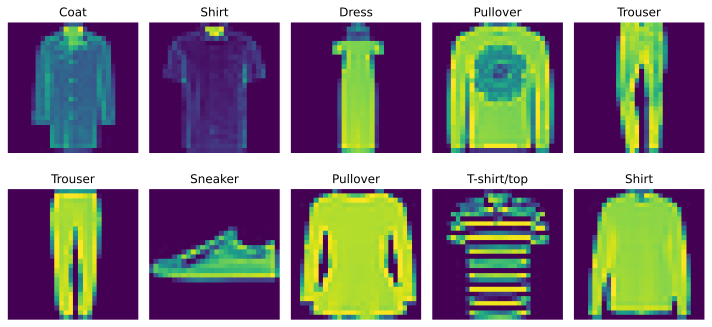

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fmnist_train[randidx[i]][0].permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"{fmnist_train.classes[fmnist_train[randidx[i]][1]]}")
plt.tight_layout()
plt.show()

In [5]:
fmnist_train[0][0].shape

torch.Size([1, 28, 28])

In [6]:
fmnist_train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
fmnist_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
train_data = torch.Tensor(np.array([x[0] for x in fmnist_train]))
train_labels = torch.tensor(np.array([x[1] for x in fmnist_train]), dtype=torch.long)
test_data = torch.Tensor(np.array([x[0] for x in fmnist_test]))
test_labels = torch.tensor(np.array([x[1] for x in fmnist_test]), dtype=torch.long)

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [9]:
train_labels[0]

tensor(9)

In [10]:
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, batch_size=16, drop_last=True, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [27]:
def create_model():
    class FmnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.enc = nn.Sequential(
                nn.Conv2d(1, 128, 3, 1, 1), # 28
                nn.BatchNorm2d(128), 
                nn.ReLU(),
                nn.MaxPool2d(2), # 14
                nn.Conv2d(128, 64, 3, 1, 1),
                nn.BatchNorm2d(64), 
                nn.ReLU(),
                nn.MaxPool2d(2), # 7
                nn.Flatten(),
                nn.Linear(7*7*64, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.Dropout(p=.3),
                nn.ReLU(),
                nn.Linear(64, 10),
            )
        def forward(self, x):
            return self.enc(x)
    net = FmnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

In [28]:
net, lossfunc, _ = create_model()

In [29]:
x = torch.randn(5, 1, 28, 28)
y = test_labels[:5]
yg = y.to(device="cuda:0")
print(f"{y=}", f"{yg=}")
y_pred = net(x)
loss = lossfunc(y_pred, y)
loss, y_pred.shape, y_pred

y=tensor([9, 2, 1, 1, 6]) yg=tensor([9, 2, 1, 1, 6], device='cuda:0')


(tensor(2.3344, grad_fn=<NllLossBackward0>),
 torch.Size([5, 10]),
 tensor([[ 0.0113, -0.0020,  0.0896, -0.0411,  0.1874,  0.2724,  0.0013, -0.0872,
          -0.1538, -0.0487],
         [-0.0389,  0.0821, -0.1485, -0.0835, -0.0085,  0.0256,  0.0143,  0.1374,
           0.0538, -0.0065],
         [-0.0402,  0.1042, -0.0371,  0.0056,  0.0083, -0.0331,  0.1879, -0.1542,
          -0.0584, -0.0733],
         [ 0.0131, -0.0077, -0.0684, -0.1695,  0.0987,  0.1337, -0.0430,  0.1731,
           0.0514, -0.0360],
         [ 0.0516,  0.1652, -0.1490, -0.0916, -0.0542,  0.0698,  0.0117,  0.1121,
          -0.0433,  0.0774]], grad_fn=<AddmmBackward0>))

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [30]:
epochs = 10
def train_model():
    net, lossfunc, optimizer = create_model()
    net.to(device=device)
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for ei in range(epochs):
        net.train()
        batch_acc, batch_loss = [], []
        for x, y in train_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            batch_loss.append(loss.cpu().item())
            batch_acc.append(100*(torch.mean((torch.argmax(y_pred, axis=1)==y).float()).cpu().item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc.append(np.mean(batch_acc).item())
        train_loss.append(np.mean(batch_loss).item())

        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            x = x.to(device=device)
            y = y.to(device=device)
            y_test = net(x)
            test_loss.append(lossfunc(y_test, y).cpu().item())
            test_acc.append(100*(torch.mean((torch.argmax(y_test, axis=1)==y).float()).cpu().item()))
        print(f"Epoch {ei}, Train Loss: {train_loss[-1]:.2f}, Test Loss: {test_loss[-1]:.2f}, Train Acc: {train_acc[-1]:.2f}, Test Acc: {test_acc[-1]:.2f}")
    return train_acc, test_acc, train_loss, test_loss, net


In [31]:
train_acc, test_acc, train_loss, test_loss, net = train_model()

Epoch 0, Train Loss: 0.43, Test Loss: 0.33, Train Acc: 84.88, Test Acc: 88.52
Epoch 1, Train Loss: 0.28, Test Loss: 0.26, Train Acc: 90.05, Test Acc: 90.53
Epoch 2, Train Loss: 0.24, Test Loss: 0.24, Train Acc: 91.42, Test Acc: 91.41
Epoch 3, Train Loss: 0.21, Test Loss: 0.25, Train Acc: 92.63, Test Acc: 91.50
Epoch 4, Train Loss: 0.18, Test Loss: 0.27, Train Acc: 93.48, Test Acc: 91.39
Epoch 5, Train Loss: 0.16, Test Loss: 0.27, Train Acc: 94.04, Test Acc: 91.28
Epoch 6, Train Loss: 0.14, Test Loss: 0.26, Train Acc: 94.84, Test Acc: 92.17
Epoch 7, Train Loss: 0.13, Test Loss: 0.27, Train Acc: 95.33, Test Acc: 91.69
Epoch 8, Train Loss: 0.11, Test Loss: 0.27, Train Acc: 95.87, Test Acc: 92.35
Epoch 9, Train Loss: 0.10, Test Loss: 0.28, Train Acc: 96.23, Test Acc: 91.90


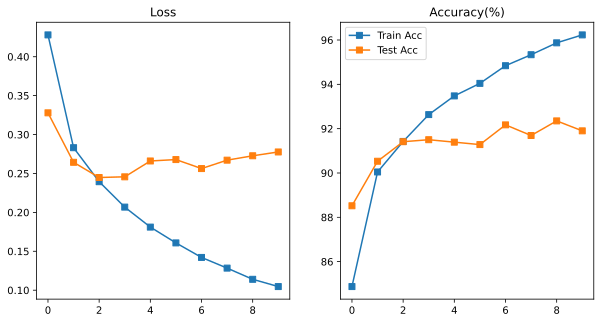

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, 's-', label="Train Loss")
ax[0].plot(test_loss, 's-', label="Test Loss")
ax[0].set_title("Loss")

ax[1].plot(train_acc, 's-', label="Train Acc")
ax[1].plot(test_acc, 's-', label="Test Acc")
ax[1].set_title("Accuracy(%)")

plt.legend()
plt.show()

## Studying T.Normalize

In [33]:
fmnist_test_t = torchvision.datasets.FashionMNIST("../data", download=True, transform=T.ToTensor(), train=False)
fmnist_test_norm = torchvision.datasets.FashionMNIST("../data", download=True, transform=trans, train=False)

In [34]:
fmnist_test_t[0][0].shape, fmnist_test_norm[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [35]:
fmnist_test_t[0][0], fmnist_test_norm[0][0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [36]:
torch.histogram(fmnist_test_t[0][0]), torch.histogram(fmnist_test_norm[0][0])

(torch.return_types.histogram(
 hist=tensor([532.,   6.,   1.,   1.,   5.,   0.,   1.,   0.,   2.,   1.,   2.,   0.,
           0.,   0.,   2.,   0.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,   0.,
           1.,   1.,   2.,   1.,   0.,   1.,   0.,   0.,   2.,   1.,   2.,   2.,
           5.,   0.,   5.,   1.,   3.,   4.,   3.,   8.,   4.,   6.,   5.,   3.,
           1.,   9.,   7.,   1.,   7.,   6.,   6.,   1.,  12.,   3.,   7.,   5.,
          13.,  10.,   6.,   7.,   4.,   7.,   5.,   4.,   2.,   5.,   0.,   0.,
           4.,   4.,   5.,   0.,   3.,   3.,   1.,   0.,   1.,   5.,   3.,   0.,
           0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           2.,   0.,   3.,   1.]),
 bin_edges=tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
         0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
         0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
         0.2700, 0.2800, 0.2

: 